# Predicting the Next Top Five Prize Money Owners' Name

### Team member : 
- Haoyu You 34735811
- Xiaomeng Zhou 67409466
- Natalia He 94652260
- Ruodan Deng 29414646

In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(ggplot2)
library(stringr)
library(readr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Introduction

# Method & Result

### Raw data

In [2]:
set.seed(1)
player <- read_csv("player_stats.csv")
player
cat("Table 1: Raw Player Data\n")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Table 1: Raw Player Data


### Tidy Data

In [3]:
set.seed(2)
player_data <- player |>
               separate(col = `Age`, into = c("age","birth_date"), sep = "\\(") |>
               mutate(age = as.integer(age)) |>
               mutate(birth_date = str_remove(birth_date, "\\)")) |>
               separate(col = `Current Rank`, into = c("current_rank","current_score"), sep = "\\(") |>
               mutate(current_rank = as.numeric(current_rank)) |>
               mutate(current_score = as.numeric(str_remove(current_score, "\\)"))) |>
               mutate(prize_money = str_remove_all(`Prize Money`, "[A-Za-z$, ]")) |>
               mutate(prize_money = as.numeric(prize_money)) |>
               mutate(name = as.character(Name)) |>
               select(age, current_rank, prize_money) |>
               filter(age != "NA",
                      current_rank != "NA",
                      prize_money != "NA")
               
player_data
cat("Table 2: Tidy Player Data\n")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,current_rank,prize_money
<int>,<dbl>,<dbl>
18,326,59040
32,178,3261567
21,236,374093
⋮,⋮,⋮
20,397,40724
20,382,57943
22,451,61984


Table 2: Tidy Player Data


### Target Data

In [4]:
first_5 <- player_data |>
           arrange(-prize_money) |>
           slice(1,2,3,4,5)
first_5
cat("Table 3: Data for each target of the top five\n")

age,current_rank,prize_money
<int>,<dbl>,<dbl>
33,1,119601561
29,11,13578010
32,12,13470614
37,200,13376235
31,9,12067808


Table 3: Data for each target of the top five


## Knn Regression

### Training data

In [5]:
set.seed(3)
player_split <- player_data |>
                initial_split(prop = 0.75, strata = prize_money)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [6]:
set.seed(4)
options(repr.plot.width = 8, repr.plot.height = 7)

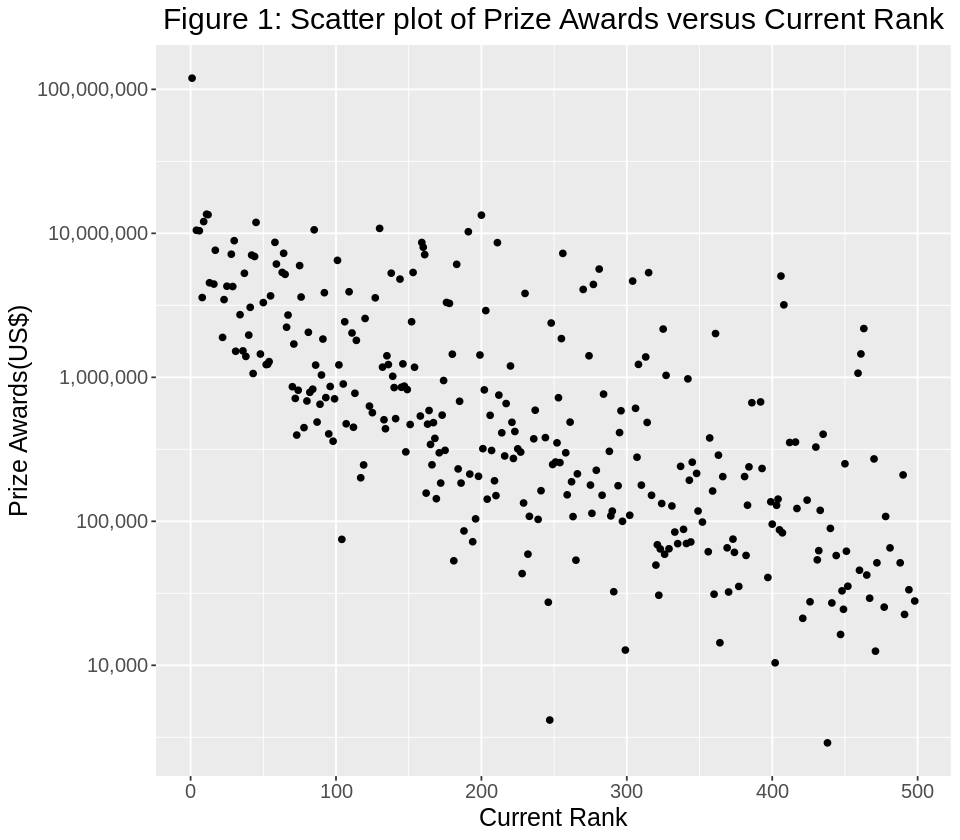

In [7]:
set.seed(5)
current_rank_plot <- player_training |>
                    ggplot(aes(x = current_rank, y = prize_money)) +
                    geom_point() +
                    labs(x = "Current Rank", y = "Prize Awards(US$)") +
                    theme(text = element_text(size = 15),
                         plot.title = element_text(hjust = 0.5)) +
                    scale_y_log10(labels = comma) +
                    ggtitle("Figure 1: Scatter plot of Prize Awards versus Current Rank")

current_rank_plot

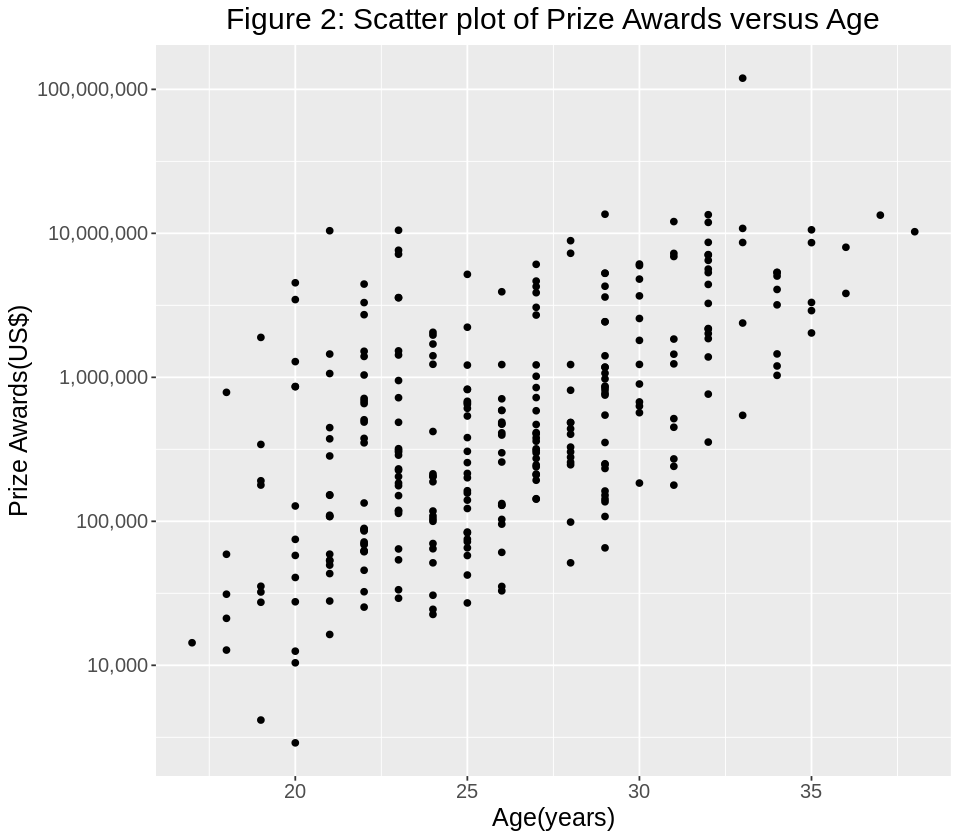

In [8]:
set.seed(6)
age_plot <- player_training |>
            ggplot(aes(x = age, y = prize_money)) +
            geom_point() +
            labs(x = "Age(years)", y = "Prize Awards(US$)") +
            theme(text = element_text(size = 15),
                  plot.title = element_text(hjust = 0.5)) +
            scale_y_log10(labels = comma) +
            ggtitle("Figure 2: Scatter plot of Prize Awards versus Age")

age_plot

### Current Rank Prediction

In [9]:
set.seed(7)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
           set_engine("kknn") |>
           set_mode("regression")

knn_recipe_cr <- recipe(prize_money ~ current_rank, data = player_training) |>
             step_center(all_predictors()) |>
             step_scale(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = prize_money)

player_workflow_cr <- workflow() |>
                     add_model(knn_spec) |>
                     add_recipe(knn_recipe_cr)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_results_cr <- player_workflow_cr |>
                    tune_grid(resample = player_vfold, grid = gridvals) |>
                    collect_metrics()

player_min_cr <- player_results_cr |>
              filter(.metric == "rmse") |>
              arrange(mean) |> 
              slice(1) |>
              pull(neighbors)

player_min_cr

[1] 49

In [10]:
set.seed(8)
player_best_spec_cr <- nearest_neighbor(weight_func = "rectangular", neighbors = 49) |>
          set_engine("kknn") |>
          set_mode("regression")

player_best_fit_cr <- workflow() |>
          add_recipe(knn_recipe_cr) |>
          add_model(player_best_spec_cr) |>
          fit(data = player_training)

player_summary_cr <- player_best_fit_cr |>
           predict(player_testing) |>
           bind_cols(player_testing)

player_summary_cr
cat("Table 4: Summary of predicted prize money based on current rank \n")

.pred,age,current_rank,prize_money
<dbl>,<int>,<dbl>,<dbl>
979868,30,293,158269
6921223,29,27,4850190
1805586,22,189,39679
⋮,⋮,⋮,⋮
832734.6,32,260,2013015
1874815.8,24,103,414637
992878.5,28,292,1048314


Table 4: Summary of predicted prize money based on current rank 


In [11]:
set.seed(9)
rmspe_cr <- player_summary_cr |>
         metrics(truth = prize_money, estimate = .pred) |>
         filter(.metric == "rmse") |>
         pull(.estimate)
rmspe_cr

[1] 1706358

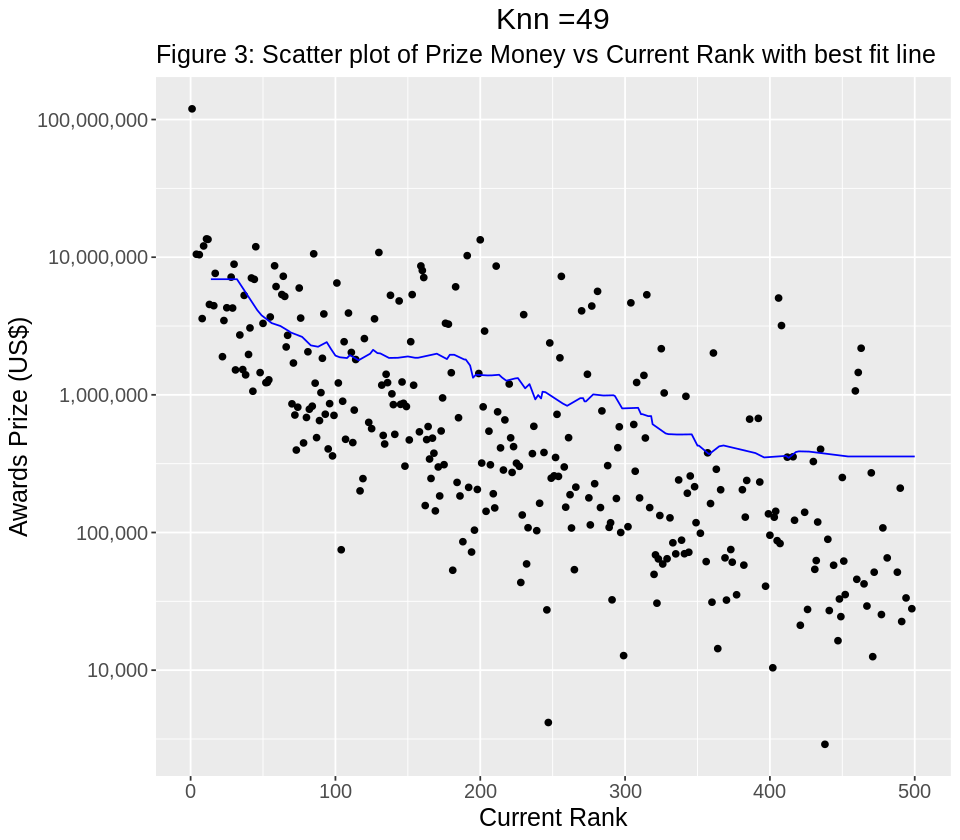

In [12]:
set.seed(10)
player_cr_plot <- ggplot(player_training, aes(x = current_rank, y = prize_money)) + 
                 geom_point() + geom_line(data = player_summary_cr,
                                          color = "blue",
                                          aes(x = current_rank, y = .pred)) +
                 scale_y_log10(labels = comma) +
                 labs(x = "Current Rank", y = 'Awards Prize (US$)') +
                 ggtitle(paste0('Knn =', 49),
             ('Figure 3: Scatter plot of Prize Money vs Current Rank with best fit line')) +
                 theme(text = element_text(size = 15),
                      plot.title = element_text(hjust = 0.5))
player_cr_plot

In [13]:
set.seed(16)
new_rank <- tibble(current_rank = c(1, 2, 3, 4, 5))

prediction_cr <- predict(player_best_fit_cr, new_rank)
prediction_cr
cat("Table 5: Predicted Pirze money based on current rank\n")

.pred
<dbl>
6921223
6921223
6921223
6921223
6921223


Table 5: Predicted Pirze money based on current rank


### Age Prediction

In [ ]:
set.seed(11)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
           set_engine("kknn") |>
           set_mode("regression")

knn_recipe_age <- recipe(prize_money ~ age, data = player_training) |>
             step_center(all_predictors()) |>
             step_scale(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = prize_money)

player_workflow_age <- workflow() |>
                     add_model(knn_spec) |>
                     add_recipe(knn_recipe_age)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_results_age <- player_workflow_age |>
                    tune_grid(resample = player_vfold, grid = gridvals) |>
                    collect_metrics()

player_age_min <- player_results_age |>
              filter(.metric == "rmse") |>
              arrange(mean) |> 
              slice(1) |>
              pull(neighbors)

player_age_min

In [ ]:
set.seed(12)
player_best_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = 59) |>
          set_engine("kknn") |>
          set_mode("regression")

player_best_fit_age <- workflow() |>
          add_recipe(knn_recipe_age) |>
          add_model(player_best_spec_age) |>
          fit(data = player_training)

player_summary_age <- player_best_fit_age |>
           predict(player_testing) |>
           bind_cols(player_testing)

player_summary_age
cat("Table 6: Summary of predicted prize money based on age \n")

In [ ]:
set.seed(13)
rmspe_age <- player_summary_age|>
         metrics(truth = prize_money, estimate = .pred) |>
         filter(.metric == "rmse") |>
         pull(.estimate)
rmspe_age

In [ ]:
set.seed(14)
player_age_plot <- ggplot(player_training, aes(x = age, y = prize_money)) + 
                 geom_point() + geom_line(data = player_summary_age,
                                          color = "blue",
                                          aes(x = age, y = .pred)) +
                 scale_y_log10(labels = comma) +
                 labs(x = "Age", y = 'Awards Prize (US$)') +
                 ggtitle(paste0('K = ', 59),
                         'Figure 4: Scatter plot of Prize Money vs Age with best fit line') +
                 theme(text = element_text(size = 15),
                      plot.title = element_text(hjust = 0.5))
player_age_plot

In [ ]:
set.seed(15)

new_age <- tibble(age = c(34,30,33,38,32))

prediction_age <- predict(player_best_fit_age, new_age)
prediction_age
cat("Table 7: Predicted Pirze money based on age\n")

### Combine prediction

In [ ]:
set.seed(17)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
           set_engine("kknn") |>
           set_mode("regression")

knn_recipe_com <- recipe(prize_money ~ current_rank + age, data = player_training) |>
             step_center(all_predictors()) |>
             step_scale(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = prize_money)

player_workflow_com <- workflow() |>
                     add_model(knn_spec) |>
                     add_recipe(knn_recipe_com)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_results_com <- player_workflow_com |>
                    tune_grid(resample = player_vfold, grid = gridvals) |>
                    collect_metrics()

player_min_com <- player_results_com |>
              filter(.metric == "rmse") |>
              arrange(mean) |> 
              slice(1) |>
              pull(neighbors)

player_min_com

In [ ]:
set.seed(18)
player_best_spec_com <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
          set_engine("kknn") |>
          set_mode("regression")

player_best_fit_com <- workflow() |>
          add_recipe(knn_recipe_com) |>
          add_model(player_best_spec_com) |>
          fit(data = player_training)

player_summary_com <- player_best_fit_com |>
           predict(player_testing) |>
           bind_cols(player_testing)

player_summary_com
cat("Table 8: Summary of predicted prize money based on current rank and age\n")

In [ ]:
set.seed(19)
rmspe_com <- player_summary_com|>
         metrics(truth = prize_money, estimate = .pred) |>
         filter(.metric == "rmse") |>
         pull(.estimate)
rmspe_com

In [ ]:
set.seed(20)
new_com <- tibble(current_rank = c(1,2,3,4,5), age = c(34,30,33,38,32))

prediction_com <- predict(player_best_fit_com, new_com)
prediction_com
cat("Table 9: Predicted Pirze money based on current rank and age\n")

# Discussion

# Reference